# This notebook is designed to explore the data

## Imports

In [1]:
# Import dependencies
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import os,sys
import json
import re
import matplotlib.pyplot as plt
from datetime import date, datetime
import dateparser
from pprint import pprint
from itertools import combinations

DATA_DIR = "data"

## Small Helper Functions

In [2]:
def to_date(d):
    return datetime.strptime(d, "%Y-%m-%d").date()

def to_time(t):
    return datetime.strptime(t[:8], "%H:%M:%S").time()

## Load clean data and county data

In [3]:
events = pd.read_csv(os.path.join(DATA_DIR, "Events_USA_2010.tsv"), delimiter="\t")
events = events.where((pd.notnull(events)), None)
county_data = None
with open(os.path.join(DATA_DIR, "county_data.json"), 'r') as _:
    county_data = json.load(_)
    
# Remove counties in state not within our consideration
remove_list = []
for fp, data in county_data.items():
    if fp[:2] in ["43", "00", "72"]:
        remove_list.append(fp)
for fp in remove_list:
    del county_data[fp]

## Plot dates/times of shootings from the clean data

In [4]:
# Collect data on dates and times of shootings
# Prefer Fine Time to Coarse Time if the record has it
event_dates = []
event_times = []
for index, event in events.iterrows():
    event_dates.append(to_date(event["Date"]))
    if event["Fine Time"]:
        event_times.append(to_time(event["Fine Time"]))
    elif event["Coarse Time"]:
        event_times.append(to_time(event["Coarse Time"]))
    else:
        event_times.append(None)

In [5]:
# Create bar charts of # events by year and # events by time of day
num_events_by_year = []
years = range(2010, 2018)
for year in years:
    start = date(year, 1, 1)
    end = date(year, 12,31)
    events_in_year = len([d for d in event_dates if d >= start and d <= end])
    num_events_by_year.append(events_in_year)
    
num_events_by_tod = []
time_ranges = [(0, 6), (6, 12), (12, 18), (18, 0)]
for tr in time_ranges:
    start = datetime.now().replace(hour=tr[0], minute=0, second=0, microsecond=0).time()
    end = datetime.now().replace(hour=(tr[1]-1) % 24, minute=59, second=59, microsecond=0).time()
    events_in_time_range = len([t for t in event_times if t and t >= start and t <= end])
    num_events_by_tod.append(events_in_time_range)
    
num_empty_times = len([t for t in event_times if not t])

print("%d total events" % len(event_times))
print("%d events with no time" % num_empty_times)

2966 total events
638 events with no time


Text(0,0.5,'Number of Gun Violence Events')

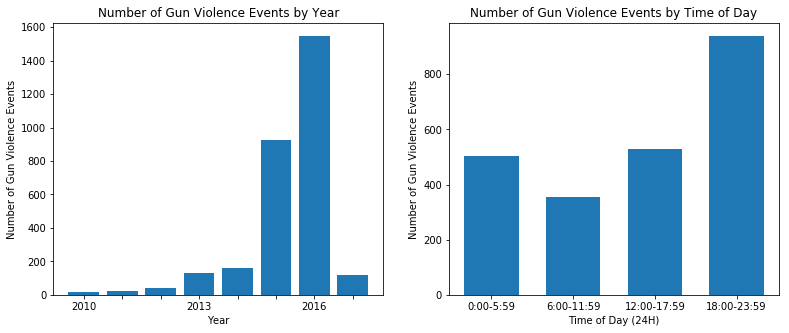

In [6]:
# Show the graphs
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].bar(years, num_events_by_year, tick_label=[str(year) if i % 3 == 0 else "" for i, year in enumerate(years)])
ax[0].set_title("Number of Gun Violence Events by Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Number of Gun Violence Events")

ax[1].bar([tr[0] for tr in time_ranges], num_events_by_tod, width=4,
        tick_label=["0:00-5:59", "6:00-11:59", "12:00-17:59", "18:00-23:59"])
ax[1].set_title("Number of Gun Violence Events by Time of Day")
ax[1].set_xlabel("Time of Day (24H)")
ax[1].set_ylabel("Number of Gun Violence Events")

The first graph indicates that our data is very heavily biased towards more recent events, and specifically 2016. No other data source cites a climb in gun violence of 800% from 2014 to 2016, so this bias is likely from more recent reports being available, or the data collection process.

The second graph indicates that between 6PM and midnight is the most likely time for gun violence to occur. It is roughly twice as likely in that time range than in any other.

## Determine how many counties are represented in our data
There are 3007 counties in the United States

In [7]:
counties = {}
for index, event in events.iterrows():
    state = event["StateFP"]
    county = event["CountyFP"]
    if state not in counties:
        counties[state] = {}
    counties[state][county] = counties[state].get(county, 0) + 1
num_counties = sum([len(c) for i,c in counties.items()])
print("Gun violence events in %d counties" % num_counties)
print("Data available on %d counties" % len(county_data))

Gun violence events in 877 counties
Data available on 3205 counties


## Verify that we have data representation for all counties

In [8]:
event_counties = {}
for index, row in events.iterrows():
    state_fp = str(row["StateFP"])
    county_fp = str(row["CountyFP"])
    state_fp = "0"*(2-len(state_fp)) + state_fp
    county_fp = "0"*(3-len(county_fp)) + county_fp
    fp = state_fp + county_fp
    event_counties[fp] = event_counties.get(fp, 0) + 1

lack_data = 0
for fp, count in event_counties.items():
    data = county_data[fp]
    if len(data) < 5:
        lack_data += 1

if lack_data == 0:
    print("Data available for all counties!")
else:
    print("Missing some data for %d counties!" % lack_data)

Data available for all counties!


## Determine statistics on number of events per county

In [9]:
count_list = []
for fp, count in event_counties.items():
    count_list.append(count)

mean_count = int(np.mean(count_list))
median_count = int(np.median(count_list))
min_count = int(np.min(count_list))
max_count = int(np.max(count_list))
print("Number of Events per County")
print("Min: %d | Max: %d | Mean: %d | Median: %d" % (min_count, max_count, mean_count, median_count))

Number of Events per County
Min: 1 | Max: 138 | Mean: 3 | Median: 1


## Determine statistics on ratio of events/population density per county

In [10]:
event_densities = []
for fp, count in event_counties.items():
    pop_density = county_data[fp]["pop_density"]
    event_density = count/pop_density
    event_densities.append(event_density)

mean_density = np.mean(event_densities)
median_density = np.median(event_densities)
min_density = np.min(event_densities)
max_density = np.max(event_densities)
print("Number of Events/Population Density per County")
print("Min: %.4f | Max: %.4f | Mean: %0.4f | Median: %0.4f" % (min_density, max_density, mean_density, median_density))

Number of Events/Population Density per County
Min: 0.0002 | Max: 29.3267 | Mean: 0.0946 | Median: 0.0110


## Sort counties into positive/negative based on events/population density

In [11]:
pos_events = []
neg_events = []
pos_X = {}
neg_X = {}
feature_labels = ["Population Density", "Education", "Unemployment", "Poverty"]
for fp, count in event_counties.items():
    data = county_data[fp]
    # Mean population from 2010 to 2017
    pop = int(np.mean([int(data["pop"][str(y)]) for y in range(2010, 2018)]))
    # Mean unemployment from 2010 to 2017
    unemp = np.mean([data["unemp"][str(y)] for y in range(2010, 2018)])
    land = data["land"]
    pop_density = data["pop_density"]
    edu = data["edu"]
    poverty = data["poverty"]
    
    event_density = count/pop_density
    X_data = [pop_density, edu, unemp, poverty]
    
    if event_density <= 0.011:
        neg_events.append(fp)
        neg_X[fp] = X_data
    else:
        pos_events.append(fp)
        pos_X[fp] = X_data
        
print("Number of Positive Events: %d" % len(pos_events))
print("Number of Negative Events: %d" % len(neg_events))

Number of Positive Events: 438
Number of Negative Events: 439


## Prepare data for feature analysis

In [12]:
data_X = []
data_Y = []
data_fips = []
for fp, data in pos_X.items():
    data_X.append(data)
    data_Y.append(1)
    data_fips.append(fp)
    
for fp, data in neg_X.items():
    data_X.append(data)
    data_Y.append(0)
    data_fips.append(fp)
    
r_index = np.arange(len(data_X))
np.random.shuffle(r_index)
data_X = np.array(data_X)[r_index]
data_Y = np.array(data_Y)[r_index]
data_fips = np.array(data_fips)[r_index]

#data_X = normalize(data_X, norm='l2', axis=1)

## Plot by combinations of features

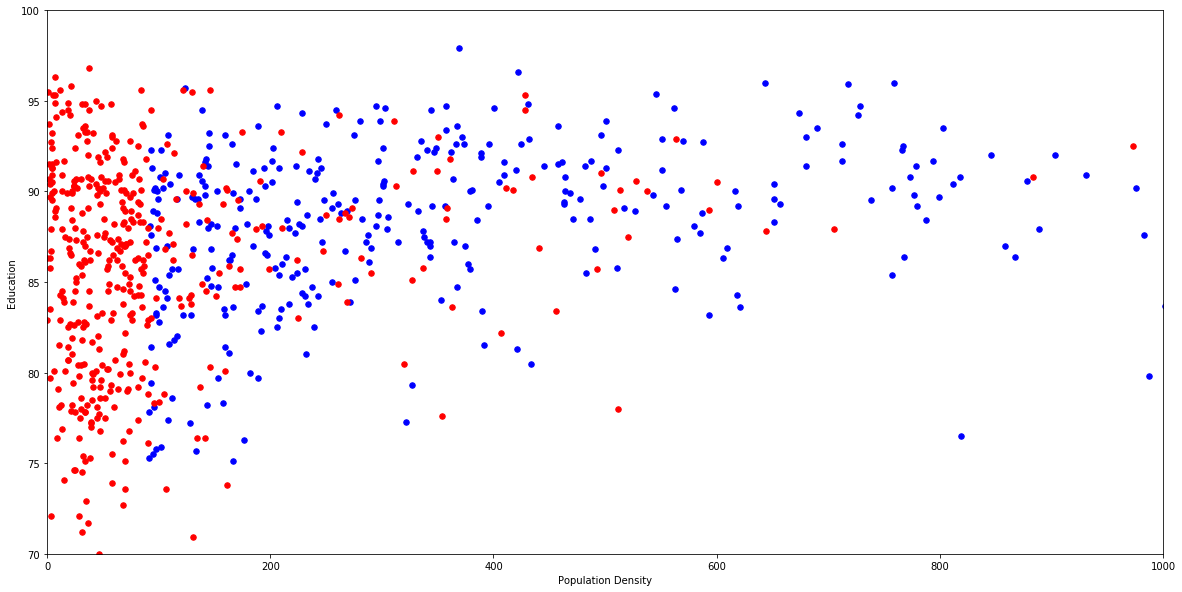

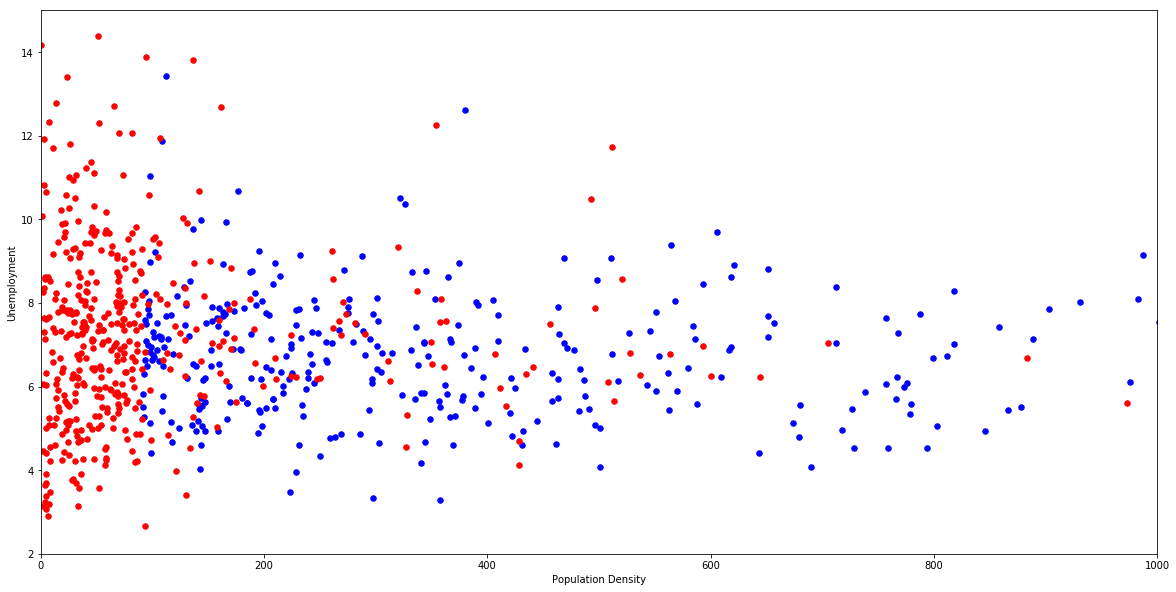

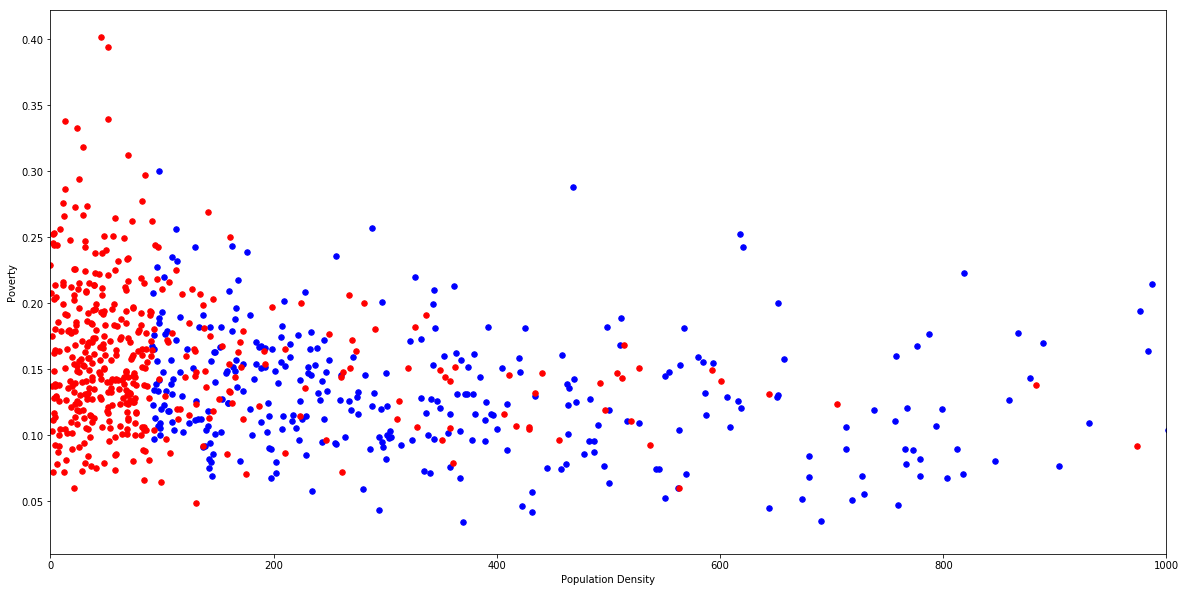

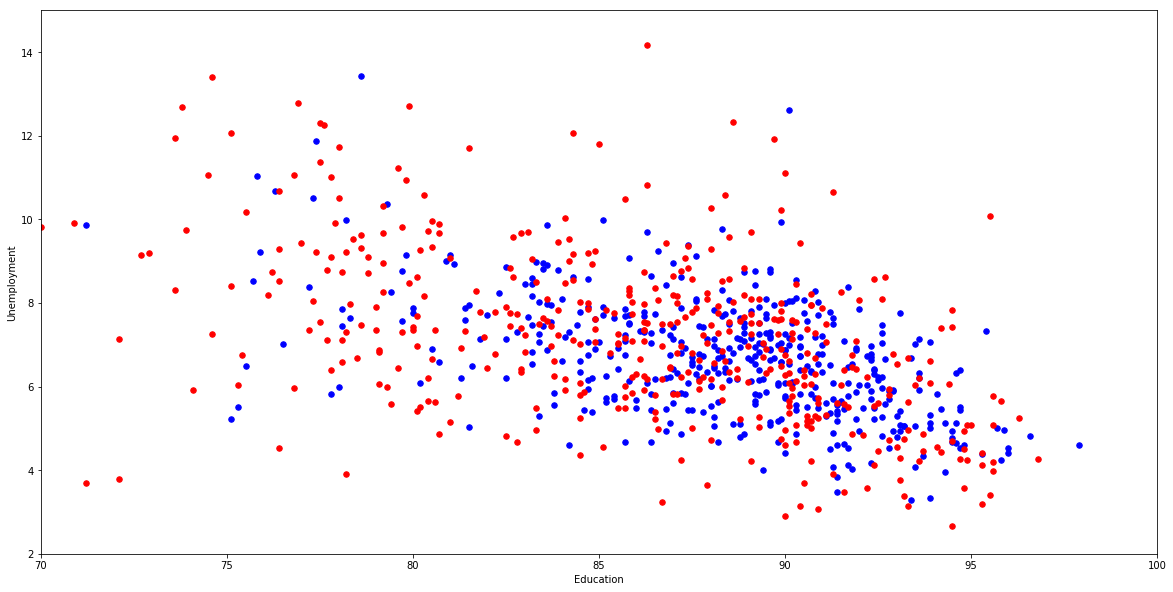

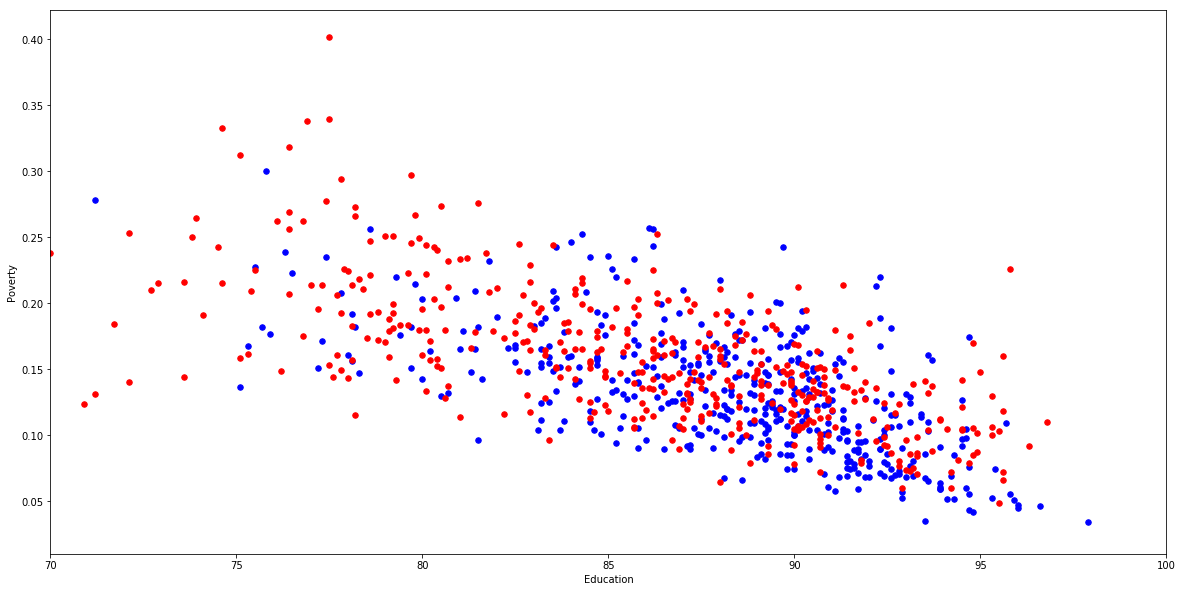

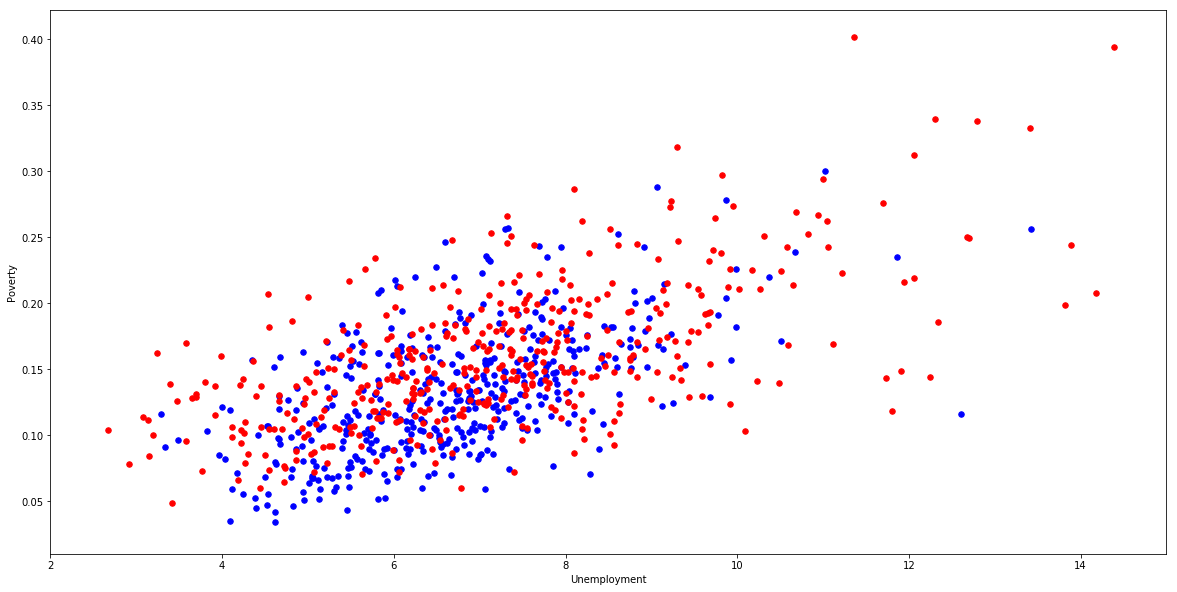

In [13]:
feature_combs = list(combinations(range(data_X.shape[1]), 2))
for comb in feature_combs:
    fx_i = comb[0]
    fx_label = feature_labels[fx_i]
    fy_i = comb[1]
    fy_label = feature_labels[fy_i]
    
    plot_X = data_X[:, (fx_i, fy_i)]
    
    fig = plt.figure(figsize=(20,10))
    for i, c, label in zip([0, 1], ['b', 'r'], ['Low Incidence', 'High Incidence']):
        plt.scatter(data_X[data_Y == i, fx_i], data_X[data_Y == i, fy_i], c=c, label=label, s=30)
    plt.xlabel(fx_label)
    plt.ylabel(fy_label)
    
    # Population Density
    if fx_i == 0:
        plt.xlim([0, 1000])
    if fy_i == 0:
        plt.ylim([0, 1000]) 
    
    # Education
    if fx_i == 1:
        plt.xlim([70, 100])
    if fy_i == 1:
        plt.ylim([70, 100])
        
    # Unemployment
    if fx_i == 2:
        plt.xlim([2, 15])
    if fy_i == 2:
        plt.ylim([2, 15])
    
    #kmeans = KMeans(init='random', n_clusters=2)
    #kmeans.fit(data_X)
    #clusters = kmeans.predict

In [14]:
for comb in feature_combs:
    fx_i = comb[0]
    fx_label = feature_labels[fx_i]
    fy_i = comb[1]
    fy_label = feature_labels[fy_i]
    